# Imputation with trained STIMP in the Northern Gulf of Mexico

In [1]:
import torch
import numpy as np 
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset

['/home/mafzhang/code/STIMP/..', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='MEXICO', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

## Fig 5a: Missing rate is equal to 0.1

In [5]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log/imputation/MEXICO/STIMP/best_0.1.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [8]:
# DINEOF
from einops import rearrange
from model.dineof_per_step import DINEOF
is_sea = np.load("./data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W], keep_non_negative_only=False)
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-08 16:00:05.038 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 167: 0.0024114695843309164, 9.750714525580406e-06
2025-05-08 16:00:05.187 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 160: 0.0022046086378395557, 9.918585419654846e-06
2025-05-08 16:00:05.335 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 160: 0.0023427773267030716, 9.896699339151382e-06
2025-05-08 16:00:05.469 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 142: 0.0021681818179786205, 9.95188020169735e-06
2025-05-08 16:00:05.634 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 176: 0.0022749281488358974, 9.920215234160423e-06
2025-05-08 16:00:05.808 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 187: 0.0016638115048408508, 9.958515875041485e-06
2025-05-08 16:00:05.915 | INFO     | model.dineof_per_step:_fit:102 - Error/Relativ

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

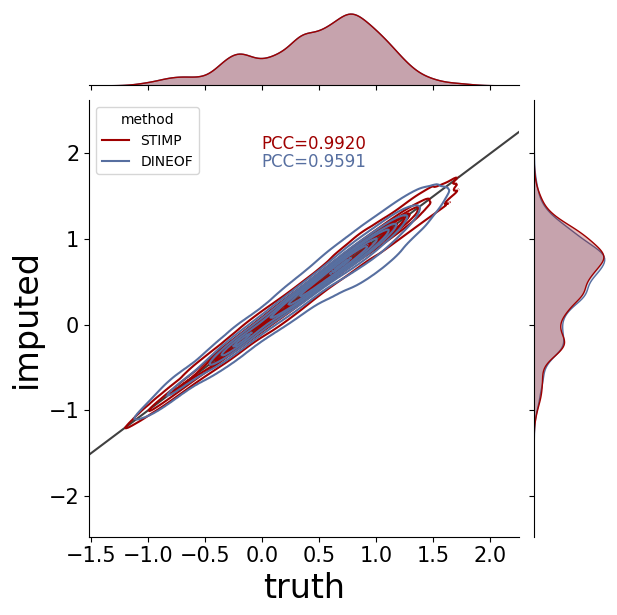

In [9]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 5a: Missing rate is equal to 0.5

In [10]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log/imputation/MEXICO/STIMP/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [11]:
# DINEOF
from einops import rearrange
from model.dineof_per_step import DINEOF
is_sea = np.load("./data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W], keep_non_negative_only=False)
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-08 16:04:03.602 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 139: 0.0015157636953517795, 9.98715404421091e-06
2025-05-08 16:04:03.784 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 184: 0.0016669080359861255, 9.927665814757347e-06
2025-05-08 16:04:03.949 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 163: 0.0015358608216047287, 9.816023521125317e-06
2025-05-08 16:04:04.065 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 118: 0.001035201014019549, 9.757932275533676e-06
2025-05-08 16:04:04.186 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 120: 0.0011178131680935621, 9.990064427256584e-06
2025-05-08 16:04:04.319 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 131: 0.0015064311446622014, 9.89111140370369e-06
2025-05-08 16:04:04.440 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative 

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

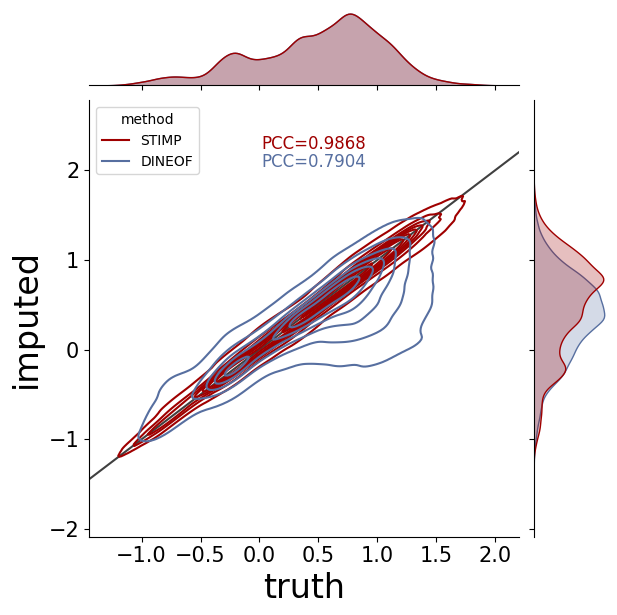

In [12]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Fig 5a: Missing rate is equal to 0.9

In [14]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log/imputation/MEXICO/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [15]:
from einops import rearrange
from model.dineof_per_step import DINEOF
is_sea = np.load("./data/MEXICO/is_sea.npy")
H, W = is_sea.shape
model = DINEOF(10, [H, W], keep_non_negative_only=False)
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
ob_mask_image = torch.zeros(1,46,1,H,W)
ob_mask_image = ob_mask_image.to(device)
ob_mask_image[:,:,:,is_sea.astype(bool)]=data_ob_masks

impute_data_list = []
for t in range(datas_image.shape[1]):
    data = datas_image[:, t, :, :, :].squeeze()

    tmp_data = torch.where(cond_mask_image[:,t].cpu().squeeze()==0, float("nan"), data.cpu())
    model.fit(tmp_data.numpy())

    imputed_data = model.predict()
    imputed_data = rearrange(imputed_data, "(b t c h) w->b t c h w", b=1, t=1, c=1, h=data.shape[-2], w=data.shape[-1])
    impute_data_list.append(torch.from_numpy(imputed_data))

imputed_data = torch.cat(impute_data_list, dim=1).numpy()

2025-05-08 16:07:26.927 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 58: 0.00015187902317848057, 9.929281077347696e-06
2025-05-08 16:07:27.000 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 74: 0.0002237727167084813, 9.703464456833899e-06
2025-05-08 16:07:27.057 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 57: 0.00017613488307688385, 9.938885341398418e-06
2025-05-08 16:07:27.113 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 57: 8.697685552760959e-05, 9.286239219363779e-06
2025-05-08 16:07:27.158 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 44: 0.00036218654713593423, 8.104776497930288e-06
2025-05-08 16:07:27.228 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative Error at iteraion 71: 4.801901013706811e-05, 7.680551789235324e-06
2025-05-08 16:07:27.270 | INFO     | model.dineof_per_step:_fit:102 - Error/Relative 

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

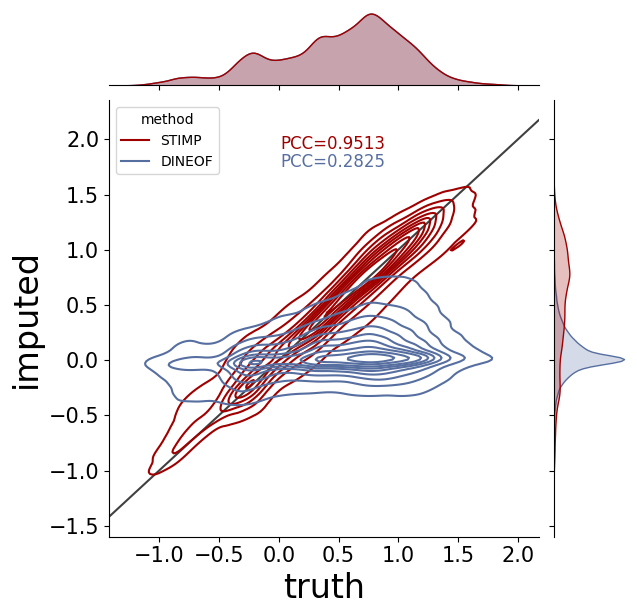

In [16]:
imputed_data_dineof = imputed_data[:,:,:,is_sea.astype(bool)]
imputed_dineof = imputed_data_dineof[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_dineof = imputed_dineof[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['DINEOF' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(2)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_dineof]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_dineof).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)